In [2]:
%reload_ext autoreload
# for auto reloading modules without kernel restart
# If this does not work to import custom modules, then restart kernel

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import timeit
from dataclasses import dataclass       # C like structure
import glob                             # finds all the pathnames matching specified pattern
!python --version
print('pandas version: ' + pd.__version__)
print('numpy version: ' + np.__version__)

Python 3.9.7
pandas version: 1.4.2
numpy version: 1.21.5


In [4]:
import sys, os
sys.path.append(os.path.join(sys.path[0], 'my_modules'))                # sys.path[0] is dir of the ipynb file
import custom_plot
import data_clean
import data_preprocess
import constants

imported custom_plot.py
data_clean imported
data_preprocess imported


In [5]:
# Static voltage related consts
STATIC_VOLTAGE_THRESHOLD = 0.1
STATIC_VOLTAGE_MIN_DURATION_SEC = 3

In [6]:
%matplotlib notebook
# Plot related packages,%matplotlib notebook makes plots in jupyter interactive

In [8]:
# This is just for test purpose

df1 = pd.DataFrame([[10, 20], [30, 40]], columns=list('AB'), index=['x', 'y'])
df2 = pd.DataFrame([["1", "2"], ["3", "4"]], columns=list('AB'), index=[1, 2])

df3 = pd.concat([df1, df2])

# li2 = (np.where(df['A']  < 5, True, False))
print(df1)
# df_out = df1.loc[df1['A'] > 10]

df2_mask = df1['A'] > 10
df1.loc[ df2_mask & (df1['B'] == 10), 'B'] = 100

print(df_out)

    A   B
x  10  20
y  30  40


NameError: name 'df_out' is not defined

In [30]:
# test
x = np.array([1,3,4,7])
y = x[..., np.newaxis]
print(y)
x = np.reshape(x, (x.shape[0], 1))
print(x.shape)
print(x)
z = np.repeat(x, 3, axis=1)
print(z)

[[1]
 [3]
 [4]
 [7]]
(4, 1)
[[1]
 [3]
 [4]
 [7]]
[[1 1 1]
 [3 3 3]
 [4 4 4]
 [7 7 7]]


In [198]:
# test code, time series shift to supervised learning

df = pd.DataFrame()
df['t'] = [x for x in range(10)]
df['t-1'] = df['t'].shift(-1)
print(df)

   t  t-1
0  0  1.0
1  1  2.0
2  2  3.0
3  3  4.0
4  4  5.0
5  5  6.0
6  6  7.0
7  7  8.0
8  8  9.0
9  9  NaN


In [67]:

df1 = pd.DataFrame({'A': [0, 0, 0, 0],
                    'B': [1, 2, 3, 4],
                    'C': np.random.randn(4)})

df2 = pd.DataFrame({'A': [-1, -1, -2, -2],
                    'B': [-1, -2, -3, -4],
                    'C': np.random.randn(4)})

li1 = [df1, df2]
# print(df2)
df_temp = df2.copy()       # must take copy, otherwise change in df_temp changes df2 and the list
df_temp['D'] = np.random.randn(4)

print(li1)
# print(df2)

[   A  B         C
0  0  1 -0.982568
1  0  2  0.156715
2  0  3 -0.753684
3  0  4  0.669448,    A  B         C
0 -1 -1  0.303304
1 -1 -2 -1.456362
2 -2 -3 -0.434801
3 -2 -4 -0.647441]


In [74]:
# This function takes a dataframe that is grouped by a column, the df must also have a timestamp col
# Filters the dataframe where each group spans over a time >= minimum time span (unit:sec)
# Params:
#     input dataframe: pandas df
#     grouped_col name: str
#     timestamp_col_name: str
#     time threshold in sec: int
# Returns: filters dataframe, remove groups that span < min_time_threshold for static voltage
def get_groups_gt_static_duration(df, grouped_col, timestamp_col):
    
    print("get_groups_gt_static_duration called")
    # rets group by obj, grouped_col as index and duration as values (no col header for duration)
    gb_duration_sec = (df.groupby(grouped_col)[timestamp_col].max() - 
                     df.groupby(grouped_col)[timestamp_col].min()).dt.total_seconds() + 1

    # Make a list of df indices, where duration > threshold
    li_gb_valid_indices = np.where(gb_duration_sec >= STATIC_VOLTAGE_MIN_DURATION_SEC,
                                   gb_duration_sec.index,
                                   np.nan)
    
    # remove nan from list and make int
    li_gb_valid_indices = [int(x) for x in li_gb_valid_indices if np.isnan(x) == False]    
    mask = df['value_grp'].isin(li_gb_valid_indices)       # true/false accross column
    df_out = df[mask].copy()

    return df_out

In [75]:
# This function takes list of dataframes, where each df contains one group of consecutive thresholded volts
# Checks whether each voltage group falls within voltage threshold limit
# Also checks for time threshold
# returns when each dataframes of the li_input_dfs list have been fully processed

# Params:
#   li_input_dfs: df groups of consecutive voltage that still needs revisit
#   li_output_dfs: filtered output dfs (both by col_val col_time) are appended in this list
#   col_volt: voltage column name that should be checked against voltage threshold, this is primary threshold check
#   col_timestamp: time col name that should be checked against time threshold, this is second filter
# Returns: when li_input_dfs has no more datafreames to process


# Algo Summary:
# iterate over li_input_dfs, each df in the list will be processed
# for each df of li_input_dfs
#   check if all element of df are within voltage threshold of df[0]
#   split df based on first occurance volt threshold fail, df1 and df_rem
#     Remove df1 from the li_input_dfs (because it has been processed)
#     check df1 against timespan threshold, if passes then append to li_output_dfs
#     check second part of splitted df, df_rem against timespan threshold
#       if time th passes, then this needs to be filtered again, call this fn recursively
#       if time th fails, then this should also be removed from li_input_dfs, i.e. li_input_dfs[id] = None
# the function returns when li_input_dfs is empty i.e. all the elements become None
# Ignore SettingWithCopyWarning for li_input_dfs and li_output_dfs ops. They are supposed to change themselves (not copy)

def valid_const_voltage_range(li_input_dfs, li_output_dfs, col_volt, col_timestamp):
    
    if(all(v is None for v in li_input_dfs)):
         return                    # all elements in input list are None, so return
    
    for i_list, df in enumerate(li_input_dfs):
        if((df is not None) and (not df.dropna().empty)):
            
            val_id0 = df.iloc[0][col_volt] # first row val of df, this will be compared with the rest
            
            li_bool = np.where((abs(df[col_volt] - val_id0) < STATIC_VOLTAGE_THRESHOLD), True, False)
            
            # get id of first occurance of false (don't confuse with df index, split_id_int starts from 0)
            if (all(li_bool)):
                split_iloc_id = len(li_bool)     # all true ie all within volt threshold
                df_rem = pd.DataFrame()          # no rem df, so empty
            else:
                split_iloc_id = np.argmax(~np.array(li_bool))     
                df_rem = df.iloc[split_iloc_id:]          # split_iloc_id -1 to end

            df1 = df.iloc[:split_iloc_id]             # 0 -> split_iloc_id -1
            
#             print("df1: ")      # debug code
#             print(df1)
            
            if(not df1.dropna().empty):
                # Remove this from input list as this has been filtered and processed
                li_input_dfs[i_list].drop(li_input_dfs[i_list].index[0:split_iloc_id], axis=0, inplace=True)

                # Check against time threshold
                if((df1.iloc[-1][col_timestamp] - df1.iloc[0][col_timestamp]).seconds + 1 >= STATIC_VOLTAGE_MIN_DURATION_SEC):
                    # add to the the output list, appending is pass by reference
                    li_output_dfs.append(df1)

            if(not df_rem.dropna().empty):
                # if remaining part < time threshold, no more processing needed
                if((df_rem.iloc[-1][col_timestamp] - df_rem.iloc[0][col_timestamp]).seconds + 1 < STATIC_VOLTAGE_MIN_DURATION_SEC):
                    li_input_dfs[i_list] = None     # no more processing needed for this df
                else:
                    # this needs processing again, recursive call
                    valid_const_voltage_range(li_input_dfs, li_output_dfs, col_volt, col_timestamp)

            if(df.dropna().empty and df_rem.dropna().empty):
                # assign None as no processing required for this df
                li_input_dfs[i_list] = None


In [76]:
def const_voltage_result(df, col_volt, col_timestamp, group_by_col):
    return pd.DataFrame({'begin_time' : df.groupby(group_by_col)[col_timestamp].min(),
                                 'end_time' : df.groupby(group_by_col)[col_timestamp].max(),
                                 'min_V' : df.groupby(group_by_col)[col_volt].min(),
                                 'max_V' : df.groupby(group_by_col)[col_volt].max(),
                                 'Consecutive' : df.groupby(group_by_col).size()})


In [77]:
# returns df in the following format, the returned df is time sorted so ready to use
#
#          begin_time  end_time  min_V  max_V  Consecutive
#     value_grp                                                          

def get_const_volt_df(df_ts, col_volt, col_timestamp):
    # Add timestamp to whole df
    df_ts[col_timestamp] = pd.to_datetime(df_ts[col_timestamp], format='%Y-%m-%d %H:%M:%S').sort_values()

    # If diff between consecutive rows <= threshold, then adds 0 (false) so cumsum remains same
    df_ts['value_grp'] = (abs(df_ts[col_volt].diff()) > abs(STATIC_VOLTAGE_THRESHOLD)).astype('int64').cumsum()

    # keep rows that have more than one contiguous values
    consecutive_size = df_ts.groupby('value_grp')['value_grp'].transform('size')
    df_grouped_volt = df_ts[(consecutive_size > 1)]

    # Keep only groups that has a time span > time threshold
    df_grouped_volt_by_time = get_groups_gt_static_duration(df_grouped_volt, 'value_grp', col_timestamp)    
#     print(df_grouped_volt_by_time)

    # retunrs df that has voltage group vals as index
    # df_const_voltage_summary will be final container of continuous const voltages > time threshold
    df_const_volt = const_voltage_result(df_grouped_volt_by_time, col_volt, col_timestamp, 'value_grp')

    # df_const_volt only has consecutive values within threshold, eg. diff(row n, n+1) <= th
    # stil it can contain volt groups that span beyond threshold, eg diff(n, n+x) >= th is possible, find out those groups
    # those out_of_th groups must be reexamined with more robust algo
    boo_V_out_th = (df_const_volt['max_V'] - df_const_volt['min_V']) > STATIC_VOLTAGE_THRESHOLD

    # make list of voltage groups that cross volt threshold
    li_V_out_th = df_const_volt[boo_V_out_th].index      # index is voltage

    # Remove out of range voltages from summary df
    df_const_volt = df_const_volt[~boo_V_out_th]

    # li_V_out_th have to be re-examined as they contain diff(n, n+x) >= th
    filtered_df = df_grouped_volt_by_time[df_grouped_volt_by_time['value_grp'].isin(li_V_out_th)]

    li_VG_dfs = []               # voltage groups that should be revisited
    for x in li_V_out_th:
        li_VG_dfs.append(df_grouped_volt_by_time[df_grouped_volt_by_time['value_grp'] == x])

    # valid_const_voltage_range() function filters consecutive voltage groups completely
    # the second param li_filtered_VG_dfs will contain completely filtered dfs
    li_filtered_VG_dfs = []           # must be empty before calling the function as it will contains output
    valid_const_voltage_range(li_VG_dfs, li_filtered_VG_dfs, col_volt, col_timestamp)

    # convert to result df format
    li_temp_result = [const_voltage_result(df, col_volt, col_timestamp, 'value_grp') for df in li_filtered_VG_dfs]

    if(len(li_temp_result)):
        df_temp_result = pd.concat(li_temp_result)                     # concat all dfs into one df
        df_const_volt = pd.concat([df_const_volt, df_temp_result])     # concat temp result df to output result df

    # print(li_filtered_VG_dfs)
    # print(df_const_volt)

    return df_const_volt

In [79]:
# create dummy time series data
# 3 days, 24 hours, 60 minutes, 60 sec each
periods = 1 * 24 * 60 * 60
tidx = pd.date_range('2021-01-13', periods=periods, freq='S')
#                     ^                                   ^
#                     |                                   |
#                 Start Date        Frequency Code for Second
# This should get me 3 Days worth of seconds in a datetimeindex

# Generate random data with numpy.  We'll seed the random
# number generator so that others can see the same results.
# Otherwise, you don't have to seed it.
np.random.seed([3,1415])

# This will pick a number of normally distributed random numbers
# where the number is specified by periods
data = np.random.randn(periods)

ts = pd.Series(data=data, index=tidx, name='dummy_data')

df_ts = pd.DataFrame({'timestamp':ts.index, 'rand_num':ts.values})       # convert series to dataframe

df_ts.insert(2, 'Number', range(1, 1 + len(df_ts)))           # new col with incrasing by 1

# print(len(df_ts['Number']))    # 86400 rows

# Add timestamp to whole df
df_ts['timestamp'] = pd.to_datetime(df_ts['timestamp'], format='%Y-%m-%d %H:%M:%S').sort_values()

df_ts = df_ts.head(50)

# update values for testing threshold algo
df_ts.loc[1:5, 'Number'] = 1.01, 1, 1.1, 1.05, 1.35
df_ts.loc[12:14, 'Number'] = 0.5, 0.56, 2.4
df_ts.loc[20:24, 'Number'] = 0.86, 0.9, 0.83, 0.92, 0.98      # test this scenario
df_ts.loc[27:29, 'Number'] = 3.8, 3.88, 3.82

# remove some timestamps to test split_on_time_gap function
df_ts.drop(df_ts.index[32:37], axis=0, inplace=True)       # remove 5 consecutive seconds of data (rows 32 to 36)
df_ts.drop(df_ts.index[40:43], axis=0, inplace=True)       # remove 3 consecutive seconds of data (rows 40 to 42)


In [80]:
def get_contiguous_ts_list(df, col, gap):
    # If diff between consecutive rows <= gap, then adds 0 (false) so cumsum remains same
    df['time_group'] = (abs(df[col].diff().dt.total_seconds()) > gap).astype('int64').cumsum()
    gb = df.groupby('time_group')
    return [gb.get_group(x) for x in gb.groups]

In [81]:
# test split_on_time_gap
li_continuous_series = get_contiguous_ts_list(df_ts, 'timestamp', 4)
# print(li_continuous_series)

In [61]:
df_const_V = get_const_volt_df(df_ts, 'Number', 'timestamp')

if(not df_const_V.dropna().empty):
    # sort by time
    print(type(df_const_V['begin_time']))  # series, so convert it to time
    df_const_V['begin_time'] = pd.to_datetime(df_const_V['begin_time'], format='%Y-%m-%d %H:%M:%S')
    df_const_V['end_time'] = pd.to_datetime(df_const_V['end_time'], format='%Y-%m-%d %H:%M:%S')
    df_const_V.sort_values('begin_time', inplace=True)   # sort all cols based on begin_time
    # print(df_test)

print(df_const_V)

get_groups_gt_static_duration called
             timestamp  rand_num  Number  time_group  value_grp
0  2021-01-13 00:00:00 -2.129724    1.00           0          0
1  2021-01-13 00:00:01 -1.268466    1.01           0          0
2  2021-01-13 00:00:02 -1.970500    1.00           0          0
20 2021-01-13 00:00:20 -0.959443    0.86           0         16
21 2021-01-13 00:00:21  1.494226    0.90           0         16
22 2021-01-13 00:00:22 -0.346508    0.83           0         16
23 2021-01-13 00:00:23 -1.471558    0.92           0         16
24 2021-01-13 00:00:24  1.063243    0.98           0         16
27 2021-01-13 00:00:27  0.296212    3.80           0         19
28 2021-01-13 00:00:28 -0.774732    3.88           0         19
29 2021-01-13 00:00:29  0.831452    3.82           0         19
df1: 
             timestamp  rand_num  Number  time_group  value_grp
20 2021-01-13 00:00:20 -0.959443    0.86           0         16
21 2021-01-13 00:00:21  1.494226    0.90           0         

C:\Users\s.kaiser\AppData\Local\Temp\ipykernel_16940\153666202.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  li_input_dfs[i_list].drop(li_input_dfs[i_list].index[0:split_iloc_id], axis=0, inplace=True)


In [82]:
#print(df_const_V['begin_li_input_dfs[i_list].drop(li_input_dfs[i_list].index[0:split_iloc_id], axis=0, inplace=True)time'].dtype)

df_const_V['next_begin_time'] = df_const_V['begin_time'].shift(-1)  # insert next start date in the same column
print(df_const_V.to_string())
li_dynamic_V = []

# append dynamic voltage to new df
def append_dynamic_voltage(index, ts1, ts2):
    df_between_ts1_ts2 = df_ts[(df_ts['timestamp'] > ts1) & (df_ts['timestamp'] < ts2)].copy()
    df_between_ts1_ts2['value_grp'] = index
    if((df_between_ts1_ts2 is not None) and (not df_between_ts1_ts2.dropna().empty)):
        li_dynamic_V.append(df_between_ts1_ts2)

[append_dynamic_voltage(x, y, z) for x, y, z in zip(df_const_V.index, df_const_V['end_time'], df_const_V['next_begin_time'])]

print(li_dynamic_V)

                   begin_time            end_time  min_V  max_V  Consecutive     next_begin_time
value_grp                                                                                       
0         2021-01-13 00:00:00 2021-01-13 00:00:02   1.00   1.01            3 2021-01-13 00:00:20
16        2021-01-13 00:00:20 2021-01-13 00:00:23   0.83   0.92            4 2021-01-13 00:00:27
19        2021-01-13 00:00:27 2021-01-13 00:00:29   3.80   3.88            3                 NaT
[             timestamp  rand_num  Number  time_group  value_grp
3  2021-01-13 00:00:03 -2.259055    1.10           0          0
4  2021-01-13 00:00:04 -0.349286    1.05           0          0
5  2021-01-13 00:00:05 -0.026955    1.35           0          0
6  2021-01-13 00:00:06  0.316236    7.00           0          0
7  2021-01-13 00:00:07  0.348782    8.00           0          0
8  2021-01-13 00:00:08  0.715364    9.00           0          0
9  2021-01-13 00:00:09  0.770763   10.00           0          0
10

In [95]:
for (i, df) in enumerate(li_dynamic_V):
#     print(i)
    print(df.shape[0])
    duration_sec = df.loc[-1] - df.loc[0]
    V_avg = 
    I_avg = 
    T_avg = 
#     df.shape(0)        # df len
    

17
3


In [38]:
# custom_plot.plot_dual_axis((df.index, "Time"), (df_ts['rand_num'], "rand"), (df['rand_num_plus5'], "plus"))

In [ ]:
# Drive cycle detection algorithm
# It becomes insanely difficlut to do it with huge data
# Explanation of why you should not loop through in pandas dataframe
# https://stackoverflow.com/questions/16476924/how-to-iterate-over-rows-in-a-dataframe-in-pandas
# speedup can be done using vector: https://python.plainenglish.io/pandas-how-you-can-speed-up-50x-using-vectorized-operations-d6e829317f30
# Get all monotonic sublists from a list

start_v = df['rand_num_plus5']
start_t

end_v
end_t

<IPython.core.display.Javascript object>


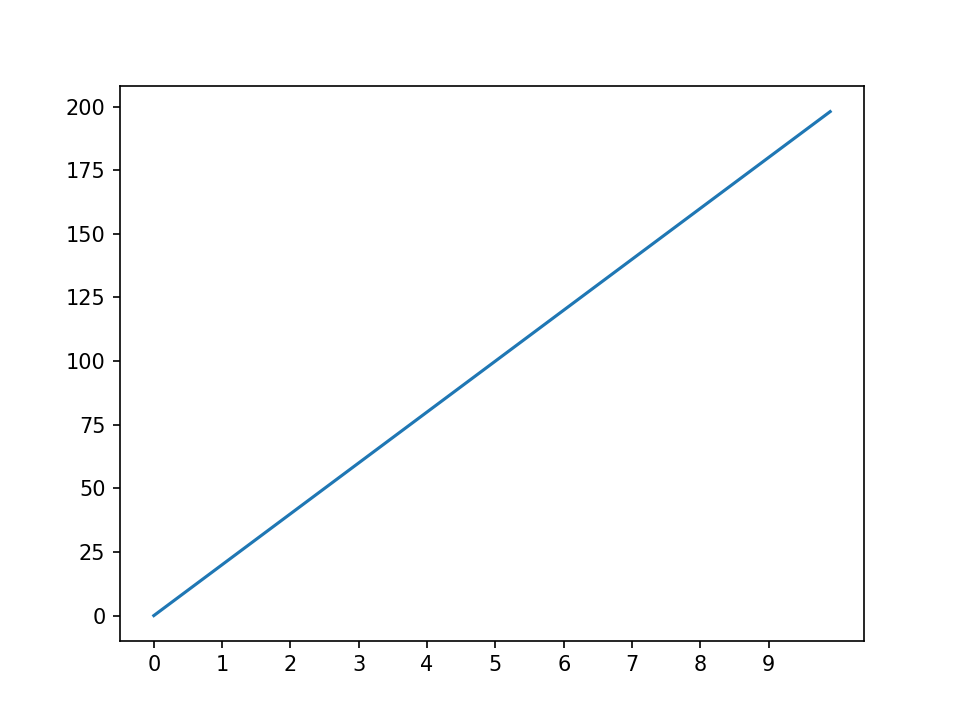

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [121]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

x = np.arange(100)
y = list(map(lambda x: x*2, np.arange(100)))

scale_x = 10

# ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:i}'.format(x/scale_x))
# ax2.xaxis.set_major_formatter(ticks_x)

plt.plot(x,y)
li_ticks = np.arange(min(x), max(x)+1, 10)
li_labels = list(map(lambda x: int(x/10), li_ticks))
print(li_labels)
plt.xticks(li_ticks, li_labels)
# plt.xaxis.set_major_formatter(ticks_x)
# plt.xticks(ticks_x)

plt.show()

<IPython.core.display.Javascript object>


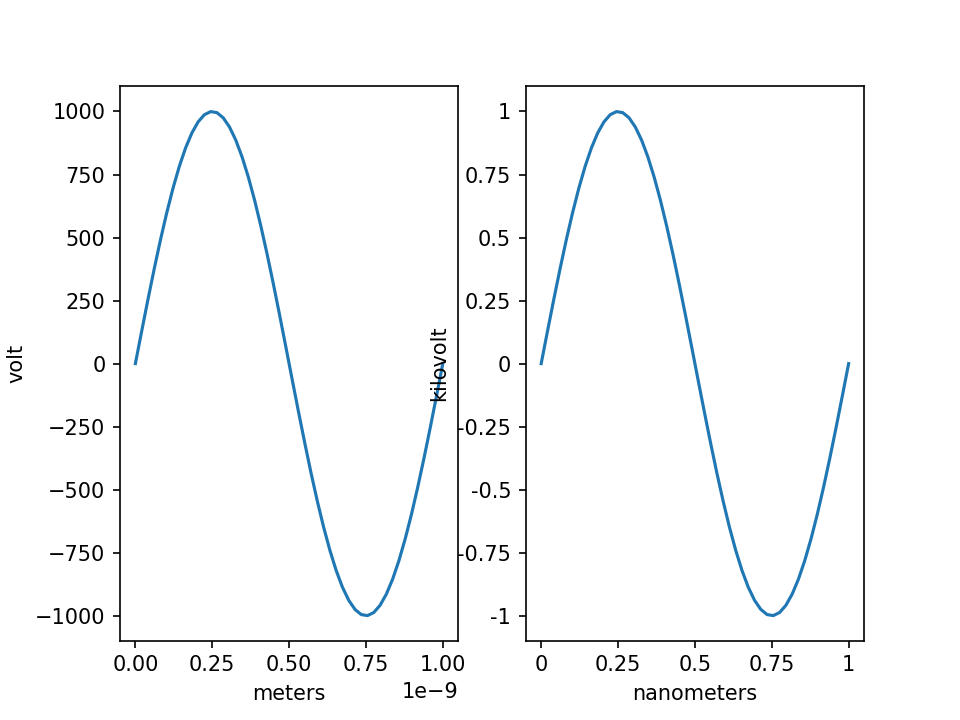

In [118]:
import numpy as np
import pylab as plt
import matplotlib.ticker as ticker

# Generate data
x = np.linspace(0, 1e-9)
y = 1e3*np.sin(2*np.pi*x/1e-9) # one period, 1k amplitude

# setup figures
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
# plot two identical plots
ax1.plot(x, y)
ax2.plot(x, y)

# Change only ax2
scale_x = 1e-9
scale_y = 1e3
ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_x))
ax2.xaxis.set_major_formatter(ticks_x)

ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax2.yaxis.set_major_formatter(ticks_y)

ax1.set_xlabel("meters")
ax1.set_ylabel('volt')
ax2.set_xlabel("nanometers")
ax2.set_ylabel('kilovolt')

plt.show() 


In [4]:
from datetime import datetime, timedelta
import pandas as pd

# Construct dummy dataframe
dates = pd.to_datetime([
    '2016-08-03',
    '2016-08-04',
    '2016-08-05',
    '2016-08-17',
    '2016-09-05',
    '2016-09-06',
    '2016-09-07',
    '2016-09-19'])
df = pd.DataFrame(dates, columns=['date'])

# Take the diff of the first column (drop 1st row since it's undefined)
deltas = df['date'].diff()[1:]

# Filter diffs (here days > 1, but could be seconds, hours, etc)
gaps = deltas[deltas > timedelta(days=1)]

# Print results
# print(f'{len(gaps)} gaps with average gap duration: {gaps.mean()}')

for i, g in gaps.iteritems():
    print(i)         # row at which gap happens
    
start_index = 0
for i, g in gaps.iteritems():
    df[start_index, i]
    gap_start = df['date'][i - 1]
    print(f'Start: {datetime.strftime(gap_start, "%Y-%m-%d")} | '
          f'Duration: {str(g.to_pytimedelta())}')


3
4
7
Start: 2016-08-05 | Duration: 12 days, 0:00:00
Start: 2016-08-17 | Duration: 19 days, 0:00:00
Start: 2016-09-07 | Duration: 12 days, 0:00:00
